# Multi-Stage Training

This notebook shows how to train a neural network to predict secondary
structures using different 

In [1]:
import numpy as np
from diurnal import database, structure, train, evaluate, transform, visualize
from diurnal.models import deep
from diurnal.models.deep import cnn
from torch import optim, nn

In [2]:
database.download("./data/", "archiveII")
SRC = "./data/archiveII/"  # Input directory containing the CT files.
SIZE = 128  # RNA molecule maximum length (longer ones are filtered out).
DST = f"./data/archiveII_processed_{SIZE}/"  # Output directory of the formatted files.
names = database.format_filenames(SRC, DST + "names.txt", SIZE)
train_names, validation_names, test_names = train.split(
    names, (0.8, 0.1, 0.1)
)

2024-06-02T19:55:46.827387 > INFO Download and install an RNA database.
2024-06-02T19:55:46.857567 >     The dataset `archiveII` is already downloaded at `./data/archiveII`.
2024-06-02T19:55:46.860540 > INFO Extract the filenames from the directory `./data/archiveII/`.


100%|██████████| 3975/3975 [00:10<00:00, 383.61it/s]


2024-06-02T19:55:57.253625 >     Detected 3975 files. Kept 2326 files.
2024-06-02T19:55:57.286826 >     The file `./data/archiveII_processed_128/names.txt` already contains the names.


In [3]:
def format(dst: str, names: list[str]):
    # Primary structures
    pp_half_scalar = lambda x, y: transform.halve_matrix(
        structure.Primary.to_matrix(
            x, y, structure.Schemes.IUPAC_PAIRINGS_SCALARS
        )
    )
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_half_scalar.npy",
        SIZE, pp_half_scalar
    )
    database.format_primary_structure(
        names, f"{dst}primary_masks.npy", SIZE, structure.Primary.to_mask
    )
    # Secondary structures.
    half_distance_formatter = lambda x, y: transform.halve_matrix(
        structure.Secondary.to_distance_matrix(x, y, power=5)
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_distance_half.npy",
        SIZE, half_distance_formatter
    )
    half_distance_formatter = lambda x, y: transform.halve_matrix(
        structure.Secondary.to_distance_matrix(x, y, power=2)
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_distance_half_2.npy",
        SIZE, half_distance_formatter
    )
    half_contact = lambda x, y: transform.halve_matrix(
        structure.Secondary.to_matrix(x, y)
    )
    database.format_secondary_structure(
        names, f"{dst}contact_half.npy", SIZE, half_contact
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_contact.npy", SIZE,
        structure.Secondary.to_matrix
    )

In [4]:
format(f"{DST}validation/", validation_names)
format(f"{DST}test/", test_names)
format(f"{DST}train/", train_names)

2024-06-02T19:55:57.316645 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_half_scalar.npy`.


2024-06-02T19:55:57.324915 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_half_scalar.npy` already contains the formatted data.
2024-06-02T19:55:57.327785 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_masks.npy`.
2024-06-02T19:55:57.390369 >     The file `./data/archiveII_processed_128/validation/primary_masks.npy` already contains the formatted data.
2024-06-02T19:55:57.390369 > INFO Formatting secondary structures into `./data/archiveII_processed_128/validation/secondary_distance_half.npy`.
2024-06-02T19:55:57.495865 >     The file `./data/archiveII_processed_128/validation/secondary_distance_half.npy` already contains the formatted data.
2024-06-02T19:55:57.499391 > INFO Formatting secondary structures into `./data/archiveII_processed_128/validation/secondary_distance_half_2.npy`.
2024-06-02T19:55:57.657052 >     The file `./data/archiveII_processed_128/validation/secondary_distance_half_2.npy` alr

In [5]:
def format_data(input, output) -> tuple:
    train_set = {
        "input": (np.load(f"{DST}train/{input}.npy"), ),
        "output": np.load(f"{DST}train/{output}.npy"),
        "names": []
    }
    validation_set = {
        "input": (np.load(f"{DST}validation/{input}.npy"), ),
        "output": np.load(f"{DST}validation/{output}.npy"),
        "names": []
    }
    test_set = {
        "input": (np.load(f"{DST}test/{input}.npy"), ),
        "output": np.load(f"{DST}test/{output}.npy"),
        "target": np.load(f"{DST}test/secondary_contact.npy"),
        "mask": np.load(f"{DST}test/primary_masks.npy"),
        "names": []
    }
    return train_set, validation_set, test_set


def evaluate_model(model, data) -> list[float]:
    f1 = []
    for i in range(len(data["output"])):
        p = model.predict([data["input"][0][i]])
        p *= data["mask"][i]
        p = transform.quantize(p, True)
        t = data["target"][i]
        f1.append(evaluate.ContactMatrix.f1(t, p))
    return f1


def check(model, data, index):
    p = model.predict([data["input"][0][index]])
    t = data["target"][index]
    visualize.compare_pairings(t, transform.quantize(p * data["mask"][index], True))


In [6]:
MODEL_UNDER_TEST = cnn.Autoencoder2D

## Single Stage with a Contact Output

In [7]:
t, v, tt = format_data(
    "primary_potential_pairings_half_scalar",
    "contact_half"
)

In [8]:
N_MAX_EPOCHS = 500
model = deep.NN(
    model=MODEL_UNDER_TEST(SIZE),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.MSELoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=True,
    patience=5,
    verbosity=2,
)
model.train(t, v)

2024-06-02T19:56:02.116512 > INFO Training the model with 1860 data points.
2024-06-02T19:56:02.116512 >     Using 232 data points for validation.
2024-06-02T19:56:02.116512 >     Beginning the training.
2024-06-02T19:56:04.765783 >   0 / 500 [                                                  ] Loss: 0.00178  Patience: 5
2024-06-02T19:56:05.257895 >   1 / 500 [                                                  ] Loss: 0.00178  Patience: 5
2024-06-02T19:56:05.756808 >   2 / 500 [                                                  ] Loss: 0.00178  Patience: 4
2024-06-02T19:56:06.226751 >   3 / 500 [                                                  ] Loss: 0.00178  Patience: 3
2024-06-02T19:56:06.696998 >   4 / 500 [                                                  ] Loss: 0.00178  Patience: 2
2024-06-02T19:56:07.170590 >   5 / 500 [                                                  ] Loss: 0.00178  Patience: 1



In [9]:
V1_f1 = evaluate_model(model, tt)
V1_f1_mean = np.mean(evaluate_model(model, tt))

In [10]:
print(V1_f1)
print(V1_f1_mean)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

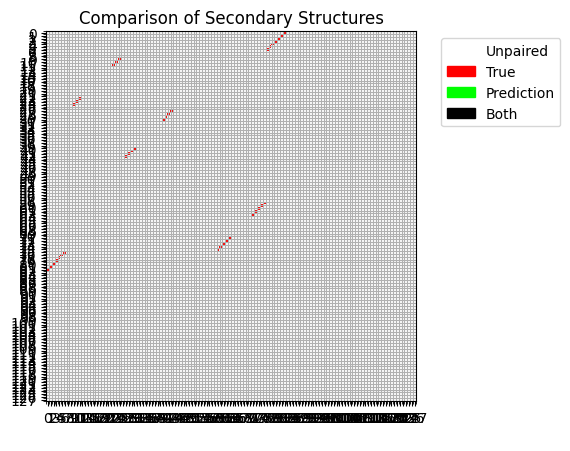

In [11]:
check(model, tt, 5)

## Single-Stage Blurry Training Autoencoder

In [12]:
t, v, tt = format_data(
    "primary_potential_pairings_half_scalar",
    "secondary_distance_half"
)
N_MAX_EPOCHS = 500
model = deep.NN(
    model=MODEL_UNDER_TEST(SIZE),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.MSELoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=True,
    patience=5,
    verbosity=2,
)
model.train(t, v)

2024-06-02T19:56:20.045700 > INFO Training the model with 1860 data points.
2024-06-02T19:56:20.045700 >     Using 232 data points for validation.
2024-06-02T19:56:20.050230 >     Beginning the training.
2024-06-02T19:56:20.802588 >   0 / 500 [                                                  ] Loss: 0.03023  Patience: 5
2024-06-02T19:56:21.271788 >   1 / 500 [                                                  ] Loss: 0.02372  Patience: 5
2024-06-02T19:56:21.727671 >   2 / 500 [                                                  ] Loss: 0.01874  Patience: 5
2024-06-02T19:56:22.176618 >   3 / 500 [                                                  ] Loss: 0.01521  Patience: 5
2024-06-02T19:56:22.747954 >   4 / 500 [                                                  ] Loss: 0.01375  Patience: 5
2024-06-02T19:56:23.206499 >   5 / 500 [                                                  ] Loss: 0.01288  Patience: 5
2024-06-02T19:56:23.687796 >   6 / 500 [                                          

In [13]:
V1_f1 = evaluate_model(model, tt)
V1_f1_mean = np.mean(evaluate_model(model, tt))
print(V1_f1)
print(V1_f1_mean)

[0.21052633225917816, 0.25581395626068115, 0.18823528289794922, 0.25287356972694397, 0.1538461595773697, 0.1355932354927063, 0.25925928354263306, 0.06896551698446274, 0.2857142686843872, 0.1860465109348297, 0.18518517911434174, 0.10526315867900848, 0.17543859779834747, 0.20224720239639282, 0.1927710771560669, 0.08219178020954132, 0.146341472864151, 0.39534884691238403, 0.11320755630731583, 0.21686747670173645, 0.3181818127632141, 0.03333333507180214, 0.0882352963089943, 0.2857142984867096, 0.0714285746216774, 0.3181818425655365, 0.29885056614875793, 0.20930232107639313, 0.222222238779068, 0.2142857164144516, 0.07499999552965164, 0.2068965584039688, 0.14814816415309906, 0.2068965584039688, 0.16470588743686676, 0.0, 0.0, 0.25287356972694397, 0.261904776096344, 0.12987013161182404, 0.0, 0.20253166556358337, 0.3448275923728943, 0.1927710771560669, 0.3636363744735718, 0.39080461859703064, 0.13636364042758942, 0.1034482792019844, 0.16438356041908264, 0.20588237047195435, 0.09302325546741486,

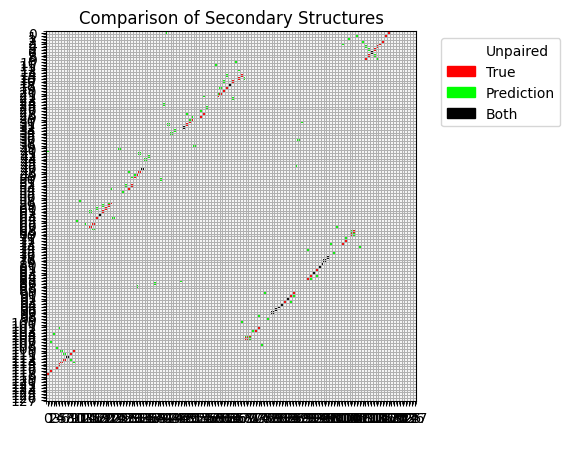

In [14]:
check(model, tt, 2)

## Single-Stage Blurry Training U-Net

In [30]:
t, v, tt = format_data(
    "primary_potential_pairings_half_scalar",
    "secondary_distance_half"
)
N_MAX_EPOCHS = 500
model = deep.NN(
    model=cnn.UNet2D(SIZE, 3),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.MSELoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=False,
    patience=10,
    verbosity=2,
)
model.train(t, v)

2024-06-02T20:03:20.959448 > INFO Training the model with 1860 data points.
2024-06-02T20:03:20.963033 >     Using 232 data points for validation.
2024-06-02T20:03:20.966061 >     Beginning the training.
2024-06-02T20:03:22.034222 >   0 / 500 [                                                  ] Loss: 0.18071  Patience: 10
2024-06-02T20:03:22.944841 >   1 / 500 [                                                  ] Loss: 0.18023  Patience: 10
2024-06-02T20:03:23.949989 >   2 / 500 [                                                  ] Loss: 0.17975  Patience: 10
2024-06-02T20:03:24.746818 >   3 / 500 [                                                  ] Loss: 0.17940  Patience: 10
2024-06-02T20:03:25.514353 >   4 / 500 [                                                  ] Loss: 0.17908  Patience: 10
2024-06-02T20:03:26.299347 >   5 / 500 [                                                  ] Loss: 0.17876  Patience: 10
2024-06-02T20:03:27.116803 >   6 / 500 [                                    

In [31]:
V1_f1 = evaluate_model(model, tt)
V1_f1_mean = np.mean(evaluate_model(model, tt))
print(V1_f1)
print(V1_f1_mean)

[0.2295082062482834, 0.4000000059604645, 0.20930233597755432, 0.2988505959510803, 0.0, 0.20000000298023224, 0.10909091681241989, 0.17543859779834747, 0.1395348757505417, 0.25287356972694397, 0.35087719559669495, 0.24561403691768646, 0.27586206793785095, 0.35164833068847656, 0.2380952388048172, 0.1666666716337204, 0.3058823347091675, 0.1818181872367859, 0.18867924809455872, 0.0952381044626236, 0.1573033630847931, 0.0, 0.17391304671764374, 0.3333333432674408, 0.07058823853731155, 0.3636363744735718, 0.1818181872367859, 0.23255814611911774, 0.25925928354263306, 0.2716049551963806, 0.12345679104328156, 0.3529411852359772, 0.18518519401550293, 0.2068965584039688, 0.31460675597190857, 0.0, 0.21052631735801697, 0.4000000059604645, 0.4418604373931885, 0.23999999463558197, 0.06741572916507721, 0.307692289352417, 0.2247191071510315, 0.3809523582458496, 0.072727270424366, 0.22727273404598236, 0.09302325546741486, 0.3103448152542114, 0.138888880610466, 0.22535212337970734, 0.1428571492433548, 0.04

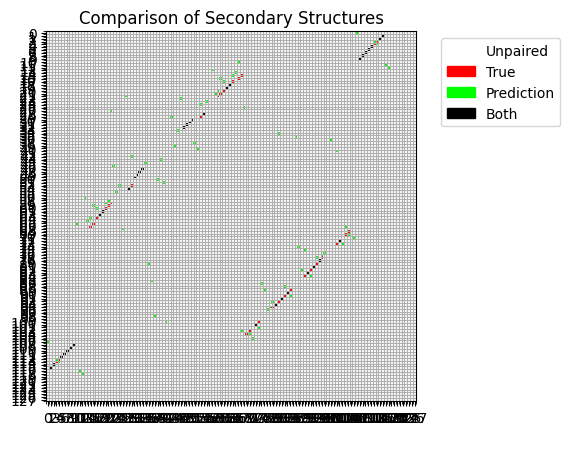

In [32]:
check(model, tt, 1)

## Single-Stage with more Blurry Input

In [16]:
t, v, tt = format_data(
    "primary_potential_pairings_half_scalar",
    "secondary_distance_half_2"
)
N_MAX_EPOCHS = 500
model = deep.NN(
    model=MODEL_UNDER_TEST(SIZE),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.MSELoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=True,
    patience=5,
    verbosity=2,
)
model.train(t, v)

NameError: name 'r' is not defined

In [ ]:
V1_f1 = evaluate_model(model, tt)
V1_f1_mean = np.mean(evaluate_model(model, tt))
print(V1_f1)
print(V1_f1_mean)

[0.10344827175140381, 0.25287356972694397, 0.09411764144897461, 0.2988505959510803, 0.05128205567598343, 0.10169491916894913, 0.23076923191547394, 0.1428571343421936, 0.24390242993831635, 0.3294117748737335, 0.1785714328289032, 0.14035089313983917, 0.2857142686843872, 0.11363636702299118, 0.1627907156944275, 0.0, 0.240963876247406, 0.2068965584039688, 0.23076923191547394, 0.07228915393352509, 0.2222222238779068, 0.10000000149011612, 0.0, 0.1204819306731224, 0.09090909361839294, 0.09090909361839294, 0.2380952537059784, 0.0941176488995552, 0.111111119389534, 0.024390244856476784, 0.07499999552965164, 0.23529411852359772, 0.14814816415309906, 0.04597701504826546, 0.13636364042758942, 0.0624999962747097, 0.1785714328289032, 0.3488372266292572, 0.1190476194024086, 0.05263158306479454, 0.0, 0.07792207598686218, 0.18823528289794922, 0.0714285746216774, 0.18518517911434174, 0.18390804529190063, 0.13333334028720856, 0.13793101906776428, 0.1690140813589096, 0.0882352888584137, 0.0238095223903656

## Three-Stage Training

In [ ]:
N_MAX_EPOCHS = 500
model = deep.NN(
    model=MODEL_UNDER_TEST(SIZE),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.MSELoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=True,
    patience=5,
    verbosity=2,
)

In [ ]:
t, v, tt = format_data(
    "primary_potential_pairings_half_scalar",
    "secondary_distance_half_2"
)
model.n_epochs = 20
model.train(t, v)

2024-06-02T15:53:21.945213 > INFO Training the model with 1860 data points.
2024-06-02T15:53:21.946793 >     Using 232 data points for validation.
2024-06-02T15:53:21.946793 >     Beginning the training.
2024-06-02T15:53:22.814153 >  0 / 20 [                                                  ] Loss: 0.03779  Patience: 5
2024-06-02T15:53:23.275011 >  1 / 20 [==                                                ] Loss: 0.02997  Patience: 5
2024-06-02T15:53:23.851039 >  2 / 20 [=====                                             ] Loss: 0.02452  Patience: 5
2024-06-02T15:53:24.344834 >  3 / 20 [=======                                           ] Loss: 0.02002  Patience: 5
2024-06-02T15:53:24.831018 >  4 / 20 [==========                                        ] Loss: 0.01792  Patience: 5
2024-06-02T15:53:25.326174 >  5 / 20 [============                                      ] Loss: 0.01687  Patience: 5
2024-06-02T15:53:25.795706 >  6 / 20 [===============                                   ] Loss

In [ ]:
t, v, tt = format_data(
    "primary_potential_pairings_half_scalar",
    "secondary_distance_half"
)
model.n_epochs = 50
model.train(t, v)

2024-06-02T15:52:30.862301 > INFO Training the model with 1860 data points.
2024-06-02T15:52:30.864351 >     Using 232 data points for validation.
2024-06-02T15:52:30.866386 >     Beginning the training.
2024-06-02T15:52:31.766560 >  0 / 50 [                                                  ] Loss: 0.03444  Patience: 5
2024-06-02T15:52:32.455636 >  1 / 50 [=                                                 ] Loss: 0.02357  Patience: 5
2024-06-02T15:52:32.993255 >  2 / 50 [==                                                ] Loss: 0.01803  Patience: 5
2024-06-02T15:52:33.474316 >  3 / 50 [===                                               ] Loss: 0.01489  Patience: 5
2024-06-02T15:52:33.975662 >  4 / 50 [====                                              ] Loss: 0.01350  Patience: 5
2024-06-02T15:52:34.518477 >  5 / 50 [=====                                             ] Loss: 0.01263  Patience: 5
2024-06-02T15:52:35.008584 >  6 / 50 [======                                            ] Loss

In [ ]:
t, v, tt = format_data(
    "primary_potential_pairings_half_scalar",
    "contact_half"
)
model.n_epochs = 20
model.train(t, v)

2024-06-02T15:53:41.936839 > INFO Training the model with 1860 data points.
2024-06-02T15:53:41.936839 >     Using 232 data points for validation.
2024-06-02T15:53:41.954209 >     Beginning the training.
2024-06-02T15:53:42.888907 >  0 / 20 [                                                  ] Loss: 0.00189  Patience: 5
2024-06-02T15:53:43.381100 >  1 / 20 [==                                                ] Loss: 0.00188  Patience: 5
2024-06-02T15:53:43.861128 >  2 / 20 [=====                                             ] Loss: 0.00192  Patience: 4
2024-06-02T15:53:44.349603 >  3 / 20 [=======                                           ] Loss: 0.00192  Patience: 3
2024-06-02T15:53:44.836083 >  4 / 20 [==========                                        ] Loss: 0.00192  Patience: 2
2024-06-02T15:53:45.315291 >  5 / 20 [============                                      ] Loss: 0.00192  Patience: 1



In [ ]:
V1_f1 = evaluate_model(model, tt)
V1_f1_mean = np.mean(evaluate_model(model, tt))
print(V1_f1)
print(V1_f1_mean)

[0.21621622145175934, 0.042553193867206573, 0.0833333358168602, 0.043478261679410934, 0.17142856121063232, 0.1666666716337204, 0.06666667014360428, 0.162162184715271, 0.1463414579629898, 0.12765957415103912, 0.15789474546909332, 0.11764706671237946, 0.125, 0.0, 0.043478261679410934, 0.25531914830207825, 0.12765957415103912, 0.08510638773441315, 0.05128205195069313, 0.04545454680919647, 0.125, 0.0, 0.1304347962141037, 0.04878048971295357, 0.0, 0.0416666679084301, 0.08510638773441315, 0.08695652335882187, 0.1538461595773697, 0.04000000283122063, 0.0, 0.0416666679084301, 0.0, 0.08510638773441315, 0.11764705926179886, 0.0, 0.05882353335618973, 0.0, 0.125, 0.0, 0.0833333283662796, 0.08695652335882187, 0.08510638773441315, 0.0416666679084301, 0.054054055362939835, 0.21276594698429108, 0.08000000566244125, 0.11428571492433548, 0.0833333283662796, 0.09090908616781235, 0.042553193867206573, 0.0555555559694767, 0.20408165454864502, 0.07692307978868484, 0.25, 0.15094339847564697, 0.0, 0.039215687